In [ ]:
# default_exp dataloader

# dataloader

> API details.

1. read_image(path: str, channels: int=3)
2. clf.load_from_folder
3. clf.load_from_csv
4. detect.load_from_xml
5. detect.load_from_csv
6. detect.load_from_json
7. detect.load_from_tfrecord

### TODO

`__len__` method impl

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
import sys
sys.path.append('../')

In [ ]:
#export
import tensorflow as tf
import pathlib
import os

import math
import matplotlib.pyplot as plt

from typing import Union

from chitra.core import remove_dsstore
from chitra.image import read_image, resize_image


In [ ]:
#export
AUTOTUNE = tf.data.experimental.AUTOTUNE

# CLF DLoader

``DataLoader class for loading dataset for image classification tasks.``
All private functions use primitive datatypes


## clf.load_from_folder
## clf.load_from_csv

In [ ]:
#export
def get_basename(path: tf.string):
    assert isinstance(path, tf.Tensor)
    return tf.strings.split(path, os.path.sep)[-1]

def show_batch(data: tf.data.Dataset, limit: int, figsize: tuple = (10,10)):
    """Visualize image and labels
    
    https://www.tensorflow.org/tutorials/load_data/images#load_using_keraspreprocessing
    
    Args:
        data: tf.data.Dataset containing image, label
        limit: number of images to display
        figsize: size of visualization
    Returns:
        Displays images and labels
    """
    assert isinstance(limit, int)
    assert isinstance(figsize, tuple)
    
    plt.figure(figsize=figsize)
    sub_plot_size = math.ceil(limit/2)
    
    for i, e in enumerate(data.take(limit)):
        image, label = e
        image = image[0].numpy().astype('uint8')
        label = label.numpy().decode()
        
        ax = plt.subplot(sub_plot_size,sub_plot_size, i+1)
        
        plt.imshow(image)
        plt.title(label.title())
        plt.axis('off')

In [ ]:
#export
class Clf(object):

    def __init__(self):
        self.CLASS_NAMES = None

    def _get_image_list(self, path: str):
        """`path`: pathlib.Path
        Returns: list of images
        """
        assert isinstance(path, str)
        list_images = tf.data.Dataset.list_files(f'{path}/*/*')
        return list_images

    def _process_path(self, path: str, size: Union[None, tuple] = None):
        """`path` :str
        `size`: None or tuple
        """
        assert isinstance(
            path,
            (str,
             tf.Tensor)), f'type of path is {type(path)}, expected type str'
        img = read_image(path)
        img = tf.py_function(resize_image, [img, (160, 160)], [tf.float32])

        label = tf.strings.split(path, os.path.sep)[-2]
        return img, label

    def from_folder(self, path: Union[str, pathlib.Path]):
        """Load dataset from given path.
        Args:
            path: string, path of folder containing dataset.
        Returns: image, label -> tf.data.Dataset prefetched with tf.data.AUTOTUNE
        """
        assert isinstance(path, (str, pathlib.Path))
        path = pathlib.Path(path)
        remove_dsstore(path)

        list_folders = tf.data.Dataset.list_files(str(path / '*'))
        list_images = self._get_image_list(str(path))

        self.CLASS_NAMES = tuple(get_basename(e).numpy() for e in list_folders)

        data = list_images.map(self._process_path, num_parallel_calls=AUTOTUNE)
        data = data.prefetch(AUTOTUNE)
        return data

In [ ]:
#hide
path = '/Users/aniketmaurya/Pictures/cats'

clf = Clf()
data = clf.from_folder(path)
data

<DatasetV1Adapter shapes: (<unknown>, ()), types: (tf.float32, tf.string)>

In [ ]:
#hide
for e in data.take(1): print(e[0].shape)

(1, 160, 160, 3)


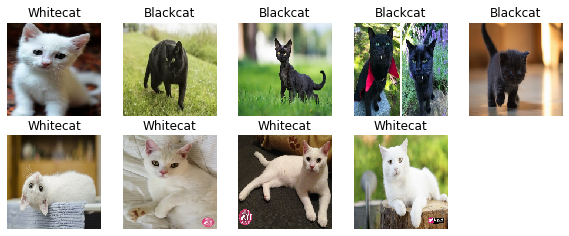

In [ ]:
show_batch(data, 9)